In [2]:
# Dependencies and Setup
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime

In [3]:
# Name of the CSV file
file = 'Historical Interest Rate Data/Historical Interest Rate Data - 1990 - 2022.xlsx'

ir_df = pd.read_excel(file, sheet_name ='Sheet1', index_col=0, dtype={'Effective Date':'datetime64[ns]', 'Cash Rate Target': float})

peaks_date = ["1994-07-27","1999-10-05","2006-04-04","2007-07-03","2009-09-02"]
timepoint = [0,30,60,90,120,150,180]

date_lst = []
timepoint_lst = []
nopeaks_lst = []
peaks_lst = []

# counter
i = 1

for dt in peaks_date:
    startdate = datetime.strptime(dt, '%Y-%m-%d')
    for t in range(len(timepoint)):
        if timepoint[t] == 0:
            enddate = startdate 
        else: enddate = startdate + timedelta(days=timepoint[t])
        peaks_lst.append(enddate)
        timepoint_lst.append(timepoint[t])
        nopeaks_lst.append(i)
        t += 1
    i += 1

# Dataframe of dates of interest and it's corresponding peaks
peaks_df = pd.DataFrame({'Peak':nopeaks_lst,'Timepoint': timepoint_lst,'Date': peaks_lst})
peaks_df.head(7)

,Peak,Timepoint,Date
0,1,0,1994-07-27
1,1,30,1994-08-26
2,1,60,1994-09-25
3,1,90,1994-10-25
4,1,120,1994-11-24
5,1,150,1994-12-24
6,1,180,1995-01-23


In [4]:
# Using Pandas grouping to group the data by Peaks
peaks_grouped = peaks_df.groupby('Peak')
# Get series of the first value of the group index
startdt_lst = peaks_grouped['Date'].first()
# Get series of the Last value of the group index
enddt_lst =  peaks_grouped['Date'].last()

In [5]:
# Create a function to make a mask
def Inbetween_(start_date, end_date):
    mask = (ir_df.index > start_date) & (ir_df.index <= end_date)
    return mask 

# Data Splice to different group
Peak_1 = ir_df[Inbetween_(startdt_lst.values[0],enddt_lst.values[0])]
Peak_2 = ir_df[Inbetween_(startdt_lst.values[1],enddt_lst.values[1])]
Peak_3 = ir_df[Inbetween_(startdt_lst.values[2],enddt_lst.values[2])]
Peak_4 = ir_df[Inbetween_(startdt_lst.values[3],enddt_lst.values[3])]
Peak_5 = ir_df[Inbetween_(startdt_lst.values[4],enddt_lst.values[4])]

In [6]:
#GETTING ASX STOCK DATA
# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '1991-01-01'
end_date = '2021-12-31'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = data.DataReader('^AXJO', 'yahoo', start_date, end_date)

# Create a function to make a mask
def Inbetween_(start_date, end_date,df):
    mask = (df.index > start_date) & (df.index <= end_date)
    return mask 

# Data Splice to different group
Stock_Peak_1 = panel_data[Inbetween_(startdt_lst.values[0],enddt_lst.values[0],panel_data)]
Stock_Peak_2 = panel_data[Inbetween_(startdt_lst.values[1],enddt_lst.values[1],panel_data)]
Stock_Peak_3 = panel_data[Inbetween_(startdt_lst.values[2],enddt_lst.values[2],panel_data)]
Stock_Peak_4 = panel_data[Inbetween_(startdt_lst.values[3],enddt_lst.values[3],panel_data)]
Stock_Peak_5 = panel_data[Inbetween_(startdt_lst.values[4],enddt_lst.values[4],panel_data)]

# Save plot 
panel_data.to_csv('panel_data.csv')

# Put everything in the list for easy access
IR_peak_lst = [Peak_1,Peak_2,Peak_3,Peak_4,Peak_5]
ASX_peak_lst = [Stock_Peak_1,Stock_Peak_2,Stock_Peak_3,Stock_Peak_4,Stock_Peak_5]

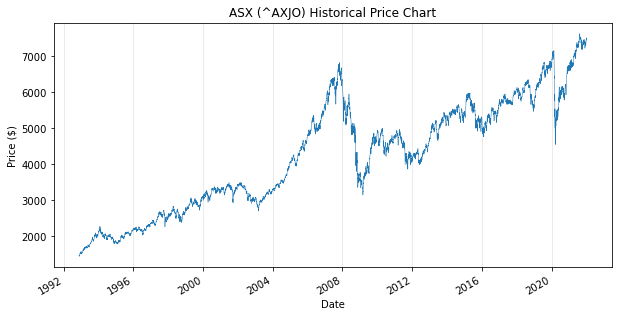

In [7]:
# Plot ASX Data
ax = panel_data['Close'].plot(figsize=(10, 5), use_index=True, ylabel='Price ($)',lw=0.5)
ax.set_title('ASX (^AXJO) Historical Price Chart')
ax.grid(axis='x', alpha=0.3)
fig = ax.get_figure()
fig.savefig("ASX CHART")

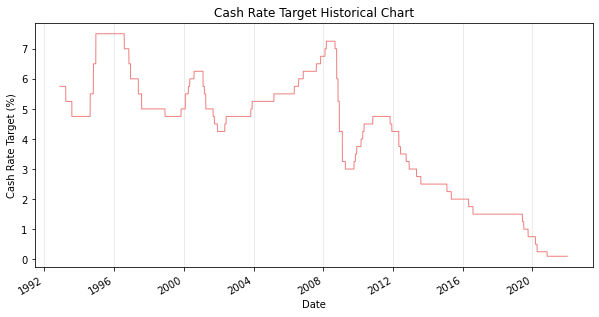

In [8]:
# Plot Interest Rate Data
ax = ir_df.plot(label='Cash',color = 'lightcoral', lw=1)
ax.set_title('Cash Rate Target Historical Chart')
ax.set_ylabel('Cash Rate Target (%)')
ax.set_xlabel('Date')
ax.get_legend().remove()
ax.grid(axis='x', alpha=0.3)
fig = ax.get_figure()
fig.set_size_inches(10,5)
fig.savefig("IR CHART")

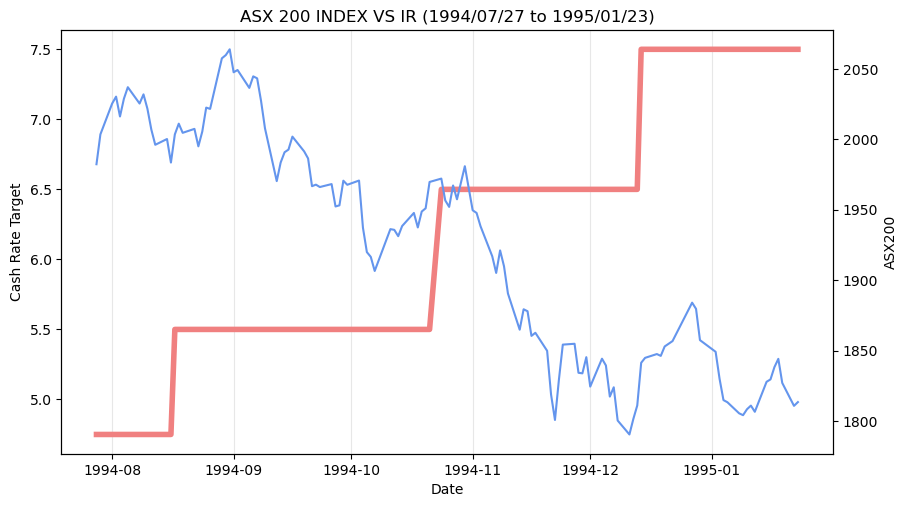

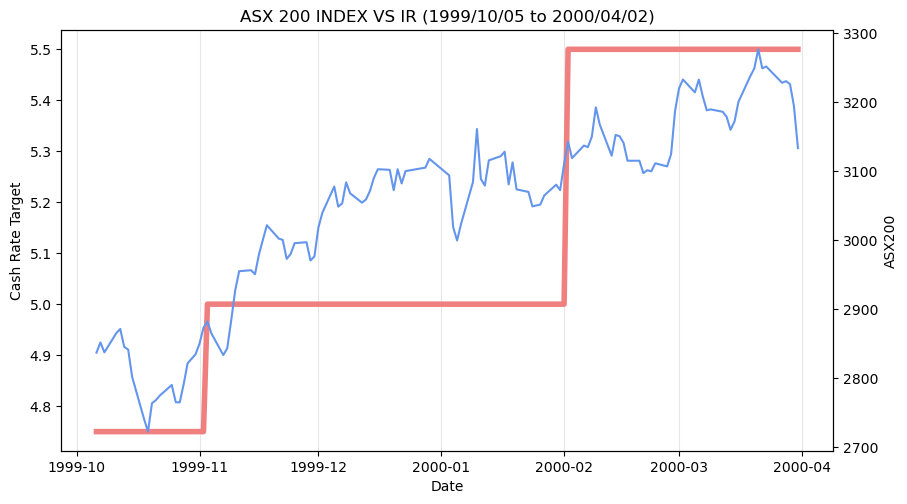

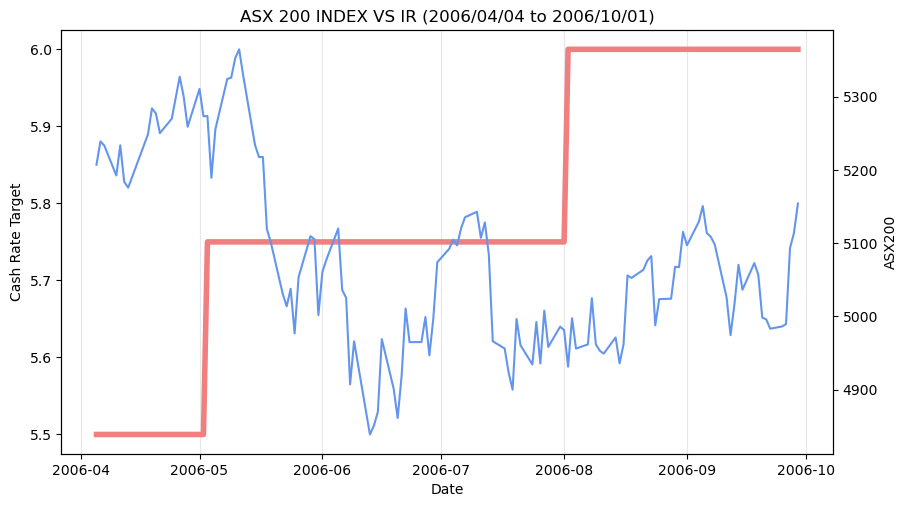

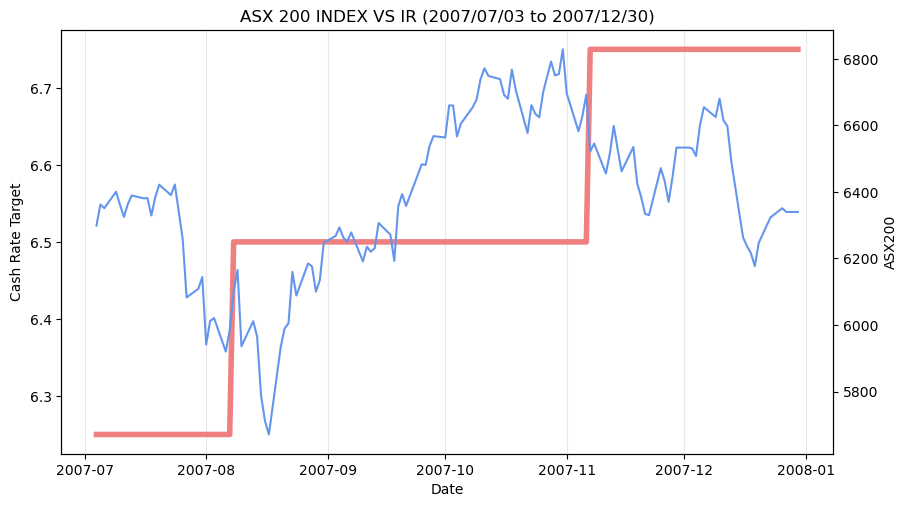

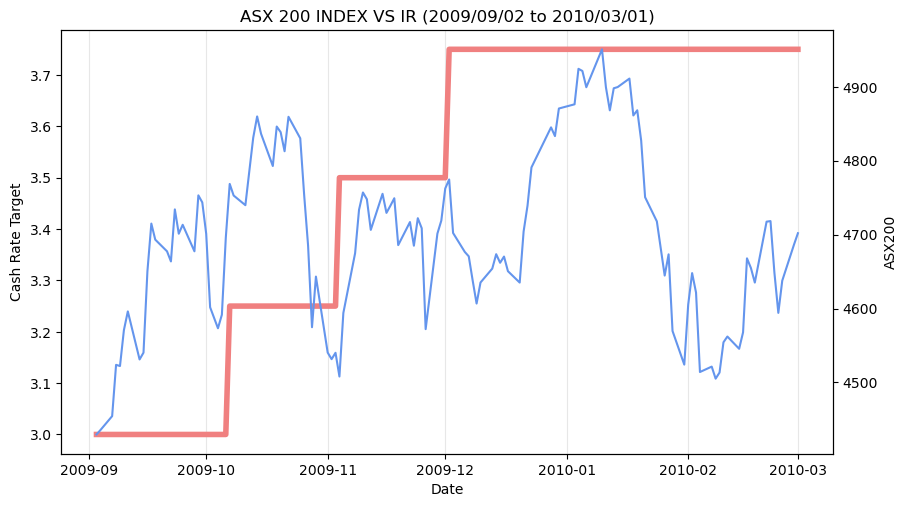

In [9]:
# Defien a function to plot similar charts
def plot_peaks(df_IR,df_peak,i):
    
    #Start Date and End date
    end_date = pd.to_datetime(enddt_lst.values[i])
    end_date = end_date.strftime('%Y/%m/%d')
   
    start_date = pd.to_datetime(startdt_lst.values[i])
    start_date = start_date.strftime('%Y/%m/%d')


    plt.style.use('default')

    fig, ax1 = plt.subplots()

    ax1.plot(df_IR, color = 'lightcoral', lw=4)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cash Rate Target')
    ax1.tick_params(axis='y')
    ax1.grid(axis='x', alpha=0.3)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.plot(df_peak['Close'], color ='cornflowerblue')
    ax2.set_ylabel('ASX200')  # we already handled the x-label with ax1
    ax2.tick_params(axis='y')
    # ax2.set_ylim([2500, 7500])

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    fig.set_size_inches(10,5)
    plt.title(f"ASX 200 INDEX VS IR ({start_date} to {end_date})")

    plt.savefig(f"Chart {i}.png")

#Define Counter
i = 0

# Iterate through the peaks we have chosen, to get charts
for i in range(len(IR_peak_lst)):
    plot_peaks(IR_peak_lst[i],ASX_peak_lst[i],i)
    i += 1

In [10]:
merge_df = pd.merge(panel_data, ir_df, on="Date", how="left")
merge_df.to_csv('merge_df.csv')

In [11]:
#-------------------------------------------------------------------
# Peak 1
#-------------------------------------------------------------------

# Set timepints 0, 30, 60, 90, 120, 150, 180
Peak_1_Start = merge_df[(merge_df.index == "1994-07-27")]
Peak_1_Start = Peak_1_Start.index[0]
Peak_1_30 = Peak_1.index[0] + timedelta(days=32)
Peak_1_60 = Peak_1.index[0] + timedelta(days=61)
Peak_1_90 = Peak_1.index[0] + timedelta(days=90)
Peak_1_120 = Peak_1.index[0] + timedelta(days=122)
Peak_1_150 = Peak_1.index[0] + timedelta(days=147)
Peak_1_180 = Peak_1.index[0] + timedelta(days=180)

# Get ASX200 value for each timepoint
peak_1_asx_0 = merge_df.loc[Peak_1_Start, "Close"]
peak_1_asx_30 = merge_df.loc[Peak_1_30, "Close"]
peak_1_asx_60 = merge_df.loc[Peak_1_60, "Close"]
peak_1_asx_90 = merge_df.loc[Peak_1_90, "Close"]
peak_1_asx_120 = merge_df.loc[Peak_1_120, "Close"]
peak_1_asx_150 = merge_df.loc[Peak_1_150, "Close"]
peak_1_asx_180 = merge_df.loc[Peak_1_180, "Close"]

# Calculate ASX200 percentage change from previous timepoint
peak_1_pct_chg_start = 0
peak_1_pct_chg_30 = (peak_1_asx_30 - peak_1_asx_0) / peak_1_asx_0
peak_1_pct_chg_60 = (peak_1_asx_60 - peak_1_asx_30) / peak_1_asx_30
peak_1_pct_chg_90 = (peak_1_asx_90 - peak_1_asx_60) / peak_1_asx_60
peak_1_pct_chg_120 = (peak_1_asx_120 - peak_1_asx_90) / peak_1_asx_90
peak_1_pct_chg_150 = (peak_1_asx_150 - peak_1_asx_120) / peak_1_asx_120
peak_1_pct_chg_180 = (peak_1_asx_180 - peak_1_asx_150) / peak_1_asx_150

# Create df
peak_1_df = pd.DataFrame({
    "Timepoint":["0 Days","30 Days","60 Days","90 Days","120 Days","150 Days","180 Days"],    
    "Date":[Peak_1_Start, Peak_1_30, Peak_1_60, Peak_1_90, Peak_1_120, Peak_1_150, Peak_1_180],
    "ASX200":[peak_1_asx_0, peak_1_asx_30, peak_1_asx_60, peak_1_asx_90, peak_1_asx_120, peak_1_asx_150, peak_1_asx_180],
    "Percentage Change":[peak_1_pct_chg_start, peak_1_pct_chg_30, peak_1_pct_chg_60, peak_1_pct_chg_90, peak_1_pct_chg_120, peak_1_pct_chg_150, peak_1_pct_chg_180],
    })

# Set % format
peak_1_df["Percentage Change"] = peak_1_df["Percentage Change"].astype(float).map("{:,.2%}".format)
peak_1_df["ASX200"] = peak_1_df["ASX200"].astype(float).map("{:,.0f}".format)

# Display df
peak_1_df


,Timepoint,Date,ASX200,Percentage Change
0,0 Days,1994-07-27,"1,982",0.00%
1,30 Days,1994-08-29,"2,058",3.80%
2,60 Days,1994-09-27,"1,952",-5.11%
3,90 Days,1994-10-26,"1,952",-0.02%
4,120 Days,1994-11-27,"1,855",-4.98%
5,150 Days,1994-12-22,"1,857",0.10%
6,180 Days,1995-01-24,"1,802",-2.94%


In [12]:
#-------------------------------------------------------------------
# Peak 2
#-------------------------------------------------------------------

# Set timepints 0, 30, 60, 90, 120, 150, 180
Peak_2_Start = merge_df[(merge_df.index == "1999-10-05")]
Peak_2_Start = Peak_2_Start.index[0]
Peak_2_30 = Peak_2.index[0] + timedelta(days=29)
Peak_2_60 = Peak_2.index[0] + timedelta(days=60)
Peak_2_90 = Peak_2.index[0] + timedelta(days=90)
Peak_2_120 = Peak_2.index[0] + timedelta(days=120)
Peak_2_150 = Peak_2.index[0] + timedelta(days=151)
Peak_2_180 = Peak_2.index[0] + timedelta(days=180)

# Get ASX200 value for each timepoint
peak_2_asx_0 = merge_df.loc[Peak_2_Start, "Close"]
peak_2_asx_30 = merge_df.loc[Peak_2_30, "Close"]
peak_2_asx_60 = merge_df.loc[Peak_2_60, "Close"]
peak_2_asx_90 = merge_df.loc[Peak_2_90, "Close"]
peak_2_asx_120 = merge_df.loc[Peak_2_120, "Close"]
peak_2_asx_150 = merge_df.loc[Peak_2_150, "Close"]
peak_2_asx_180 = merge_df.loc[Peak_2_180, "Close"]

# Calculate ASX200 percentage change from previous timepoint
peak_2_pct_chg_start = 0
peak_2_pct_chg_30 = (peak_2_asx_30 - peak_2_asx_0) / peak_2_asx_0
peak_2_pct_chg_60 = (peak_2_asx_60 - peak_2_asx_30) / peak_2_asx_30
peak_2_pct_chg_90 = (peak_2_asx_90 - peak_2_asx_60) / peak_2_asx_60
peak_2_pct_chg_120 = (peak_2_asx_120 - peak_2_asx_90) / peak_2_asx_90
peak_2_pct_chg_150 = (peak_2_asx_150 - peak_2_asx_120) / peak_2_asx_120
peak_2_pct_chg_180 = (peak_2_asx_180 - peak_2_asx_150) / peak_2_asx_150

# Create df
peak_2_df = pd.DataFrame({
    "Timepoint":["0 Days","30 Days","60 Days","90 Days","120 Days","150 Days","180 Days"],    
    "Date":[Peak_2_Start, Peak_2_30, Peak_2_60, Peak_2_90, Peak_2_120, Peak_2_150, Peak_2_180],
    "ASX200":[peak_2_asx_0, peak_2_asx_30, peak_2_asx_60, peak_2_asx_90, peak_2_asx_120, peak_2_asx_150, peak_2_asx_180],
    "Percentage Change":[peak_2_pct_chg_start, peak_2_pct_chg_30, peak_2_pct_chg_60, peak_2_pct_chg_90, peak_2_pct_chg_120, peak_2_pct_chg_150, peak_2_pct_chg_180],
    })

# Set % format
peak_2_df["Percentage Change"] = peak_2_df["Percentage Change"].astype(float).map("{:,.2%}".format)
peak_2_df["ASX200"] = peak_2_df["ASX200"].astype(float).map("{:,.0f}".format)

# Display df
peak_2_df

,Timepoint,Date,ASX200,Percentage Change
0,0 Days,1999-10-05,"2,855",0.00%
1,30 Days,1999-11-04,"2,865",0.35%
2,60 Days,1999-12-05,"3,078",7.43%
3,90 Days,2000-01-04,"3,019",-1.91%
4,120 Days,2000-02-03,"3,119",3.31%
5,150 Days,2000-03-05,"3,214",3.06%
6,180 Days,2000-04-03,"3,191",-0.72%


In [13]:
#-------------------------------------------------------------------
# Peak 3
#-------------------------------------------------------------------

# Set timepints 0, 30, 60, 90, 120, 150, 180
Peak_3_Start = merge_df[(merge_df.index == "2006-04-04")]
Peak_3_Start = Peak_3_Start.index[0]
Peak_3_30 = Peak_3.index[0] + timedelta(days=29)
Peak_3_60 = Peak_3.index[0] + timedelta(days=61)
Peak_3_90 = Peak_3.index[0] + timedelta(days=90)
Peak_3_120 = Peak_3.index[0] + timedelta(days=120)
Peak_3_150 = Peak_3.index[0] + timedelta(days=152)
Peak_3_180 = Peak_3.index[0] + timedelta(days=180)

# Get ASX200 value for each timepoint
peak_3_asx_0 = merge_df.loc[Peak_3_Start, "Close"]
peak_3_asx_30 = merge_df.loc[Peak_3_30, "Close"]
peak_3_asx_60 = merge_df.loc[Peak_3_60, "Close"]
peak_3_asx_90 = merge_df.loc[Peak_3_90, "Close"]
peak_3_asx_120 = merge_df.loc[Peak_3_120, "Close"]
peak_3_asx_150 = merge_df.loc[Peak_3_150, "Close"]
peak_3_asx_180 = merge_df.loc[Peak_3_180, "Close"]

# Calculate ASX200 percentage change from previous timepoint
peak_3_pct_chg_start = 0
peak_3_pct_chg_30 = (peak_3_asx_30 - peak_3_asx_0) / peak_3_asx_0
peak_3_pct_chg_60 = (peak_3_asx_60 - peak_3_asx_30) / peak_3_asx_30
peak_3_pct_chg_90 = (peak_3_asx_90 - peak_3_asx_60) / peak_3_asx_60
peak_3_pct_chg_120 = (peak_3_asx_120 - peak_3_asx_90) / peak_3_asx_90
peak_3_pct_chg_150 = (peak_3_asx_150 - peak_3_asx_120) / peak_3_asx_120
peak_3_pct_chg_180 = (peak_3_asx_180 - peak_3_asx_150) / peak_3_asx_150

# Create df
peak_3_df = pd.DataFrame({
    "Timepoint":["0 Days","30 Days","60 Days","90 Days","120 Days","150 Days","180 Days"],    
    "Date":[Peak_3_Start, Peak_3_30, Peak_3_60, Peak_3_90, Peak_3_120, Peak_3_150, Peak_3_180],
    "ASX200":[peak_3_asx_0, peak_3_asx_30, peak_3_asx_60, peak_3_asx_90, peak_3_asx_120, peak_3_asx_150, peak_3_asx_180],
    "Percentage Change":[peak_3_pct_chg_start, peak_3_pct_chg_30, peak_3_pct_chg_60, peak_3_pct_chg_90, peak_3_pct_chg_120, peak_3_pct_chg_150, peak_3_pct_chg_180],
    })

# Set % format
peak_3_df["Percentage Change"] = peak_3_df["Percentage Change"].astype(float).map("{:,.2%}".format)
peak_3_df["ASX200"] = peak_3_df["ASX200"].astype(float).map("{:,.0f}".format)

# Display df
peak_3_df

,Timepoint,Date,ASX200,Percentage Change
0,0 Days,2006-04-04,"5,162",0.00%
1,30 Days,2006-05-04,"5,189",0.52%
2,60 Days,2006-06-05,"5,120",-1.33%
3,90 Days,2006-07-04,"5,105",-0.30%
4,120 Days,2006-08-03,"4,998",-2.10%
5,150 Days,2006-09-04,"5,129",2.64%
6,180 Days,2006-10-02,"5,179",0.97%


In [14]:
#-------------------------------------------------------------------
# Peak 4
#-------------------------------------------------------------------

# Set timepints 0, 30, 60, 90, 120, 150, 180
Peak_4_Start = merge_df[(merge_df.index == "2007-07-03")]
Peak_4_Start = Peak_4_Start.index[0]
Peak_4_30 = Peak_4.index[0] + timedelta(days=29)
Peak_4_60 = Peak_4.index[0] + timedelta(days=61)
Peak_4_90 = Peak_4.index[0] + timedelta(days=90)
Peak_4_120 = Peak_4.index[0] + timedelta(days=120)
Peak_4_150 = Peak_4.index[0] + timedelta(days=151)
Peak_4_180 = Peak_4.index[0] + timedelta(days=181)

# Get ASX200 value for each timepoint
peak_4_asx_0 = merge_df.loc[Peak_4_Start, "Close"]
peak_4_asx_30 = merge_df.loc[Peak_4_30, "Close"]
peak_4_asx_60 = merge_df.loc[Peak_4_60, "Close"]
peak_4_asx_90 = merge_df.loc[Peak_4_90, "Close"]
peak_4_asx_120 = merge_df.loc[Peak_4_120, "Close"]
peak_4_asx_150 = merge_df.loc[Peak_4_150, "Close"]
peak_4_asx_180 = merge_df.loc[Peak_4_180, "Close"]

# Calculate ASX200 percentage change from previous timepoint
peak_4_pct_chg_start = 0
peak_4_pct_chg_30 = (peak_4_asx_30 - peak_4_asx_0) / peak_4_asx_0
peak_4_pct_chg_60 = (peak_4_asx_60 - peak_4_asx_30) / peak_4_asx_30
peak_4_pct_chg_90 = (peak_4_asx_90 - peak_4_asx_60) / peak_4_asx_60
peak_4_pct_chg_120 = (peak_4_asx_120 - peak_4_asx_90) / peak_4_asx_90
peak_4_pct_chg_150 = (peak_4_asx_150 - peak_4_asx_120) / peak_4_asx_120
peak_4_pct_chg_180 = (peak_4_asx_180 - peak_4_asx_150) / peak_4_asx_150

# Create df
peak_4_df = pd.DataFrame({
    "Timepoint":["0 Days","30 Days","60 Days","90 Days","120 Days","150 Days","180 Days"],    
    "Date":[Peak_4_Start, Peak_4_30, Peak_4_60, Peak_4_90, Peak_4_120, Peak_4_150, Peak_4_180],
    "ASX200":[peak_4_asx_0, peak_4_asx_30, peak_4_asx_60, peak_4_asx_90, peak_4_asx_120, peak_4_asx_150, peak_4_asx_180],
    "Percentage Change":[peak_4_pct_chg_start, peak_4_pct_chg_30, peak_4_pct_chg_60, peak_4_pct_chg_90, peak_4_pct_chg_120, peak_4_pct_chg_150, peak_4_pct_chg_180],
    })

# Set % format
peak_4_df["Percentage Change"] = peak_4_df["Percentage Change"].astype(float).map("{:,.2%}".format)
peak_4_df["ASX200"] = peak_4_df["ASX200"].astype(float).map("{:,.0f}".format)

# Display df
peak_4_df

,Timepoint,Date,ASX200,Percentage Change
0,0 Days,2007-07-03,"6,299",0.00%
1,30 Days,2007-08-02,"6,012",-4.56%
2,60 Days,2007-09-03,"6,267",4.25%
3,90 Days,2007-10-02,"6,660",6.26%
4,120 Days,2007-11-01,"6,697",0.55%
5,150 Days,2007-12-02,"6,534",-2.44%
6,180 Days,2008-01-01,"6,353",-2.76%


In [15]:
#-------------------------------------------------------------------
# Peak 5
#-------------------------------------------------------------------

# Set timepints 0, 30, 60, 90, 120, 150, 180
Peak_5_Start = merge_df[(merge_df.index == "2009-09-02")]
Peak_5_Start = Peak_5_Start.index[0]
Peak_5_30 = Peak_5.index[0] + timedelta(days=29)
Peak_5_60 = Peak_5.index[0] + timedelta(days=60)
Peak_5_90 = Peak_5.index[0] + timedelta(days=90)
Peak_5_120 = Peak_5.index[0] + timedelta(days=122)
Peak_5_150 = Peak_5.index[0] + timedelta(days=150)
Peak_5_180 = Peak_5.index[0] + timedelta(days=181)

# Get ASX200 value for each timepoint
peak_5_asx_0 = merge_df.loc[Peak_5_Start, "Close"]
peak_5_asx_30 = merge_df.loc[Peak_5_30, "Close"]
peak_5_asx_60 = merge_df.loc[Peak_5_60, "Close"]
peak_5_asx_90 = merge_df.loc[Peak_5_90, "Close"]
peak_5_asx_120 = merge_df.loc[Peak_5_120, "Close"]
peak_5_asx_150 = merge_df.loc[Peak_5_150, "Close"]
peak_5_asx_180 = merge_df.loc[Peak_5_180, "Close"]

# Calculate ASX200 percentage change from previous timepoint
peak_5_pct_chg_start = 0
peak_5_pct_chg_30 = (peak_5_asx_30 - peak_5_asx_0) / peak_5_asx_0
peak_5_pct_chg_60 = (peak_5_asx_60 - peak_5_asx_30) / peak_5_asx_30
peak_5_pct_chg_90 = (peak_5_asx_90 - peak_5_asx_60) / peak_5_asx_60
peak_5_pct_chg_120 = (peak_5_asx_120 - peak_5_asx_90) / peak_5_asx_90
peak_5_pct_chg_150 = (peak_5_asx_150 - peak_5_asx_120) / peak_5_asx_120
peak_5_pct_chg_180 = (peak_5_asx_180 - peak_5_asx_150) / peak_5_asx_150

# Create df
peak_5_df = pd.DataFrame({
    "Timepoint":["0 Days","30 Days","60 Days","90 Days","120 Days","150 Days","180 Days"],    
    "Date":[Peak_5_Start, Peak_5_30, Peak_5_60, Peak_5_90, Peak_5_120, Peak_5_150, Peak_5_180],
    "ASX200":[peak_5_asx_0, peak_5_asx_30, peak_5_asx_60, peak_5_asx_90, peak_5_asx_120, peak_5_asx_150, peak_5_asx_180],
    "Percentage Change":[peak_5_pct_chg_start, peak_5_pct_chg_30, peak_5_pct_chg_60, peak_5_pct_chg_90, peak_5_pct_chg_120, peak_5_pct_chg_150, peak_5_pct_chg_180],
    })

# Set % format
peak_5_df["Percentage Change"] = peak_5_df["Percentage Change"].astype(float).map("{:,.2%}".format)
peak_5_df["ASX200"] = peak_5_df["ASX200"].astype(float).map("{:,.0f}".format)

# Display df
peak_5_df

,Timepoint,Date,ASX200,Percentage Change
0,0 Days,2009-09-02,"4,438",0.00%
1,30 Days,2009-10-02,"4,602",3.68%
2,60 Days,2009-11-02,"4,532",-1.53%
3,90 Days,2009-12-02,"4,775",5.36%
4,120 Days,2010-01-03,"4,876",2.13%
5,150 Days,2010-01-31,"4,524",-7.22%
6,180 Days,2010-03-03,"4,750",5.00%
